In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt 
import numpy as np 
import pandas as pd
from PIL import Image
from tqdm import tqdm
import cv2
from pickle import dump, load

<h3>Load captions, mỗi image tương ứng có 5 caption</h3>

In [2]:
df = pd.read_csv('dataset/captions.txt')
df.head()

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...


In [3]:
IMAGE_PATH = 'dataset/images/'

In [4]:
img_path = []
for i in range(0, len(df), 5):
    img_path.append(IMAGE_PATH + df['image'][i])
img_path

['dataset/images/1000268201_693b08cb0e.jpg',
 'dataset/images/1001773457_577c3a7d70.jpg',
 'dataset/images/1002674143_1b742ab4b8.jpg',
 'dataset/images/1003163366_44323f5815.jpg',
 'dataset/images/1007129816_e794419615.jpg',
 'dataset/images/1007320043_627395c3d8.jpg',
 'dataset/images/1009434119_febe49276a.jpg',
 'dataset/images/1012212859_01547e3f17.jpg',
 'dataset/images/1015118661_980735411b.jpg',
 'dataset/images/1015584366_dfcec3c85a.jpg',
 'dataset/images/101654506_8eb26cfb60.jpg',
 'dataset/images/101669240_b2d3e7f17b.jpg',
 'dataset/images/1016887272_03199f49c4.jpg',
 'dataset/images/1019077836_6fc9b15408.jpg',
 'dataset/images/1019604187_d087bf9a5f.jpg',
 'dataset/images/1020651753_06077ec457.jpg',
 'dataset/images/1022454332_6af2c1449a.jpg',
 'dataset/images/1022454428_b6b660a67b.jpg',
 'dataset/images/1022975728_75515238d8.jpg',
 'dataset/images/102351840_323e3de834.jpg',
 'dataset/images/1024138940_f1fefbdce1.jpg',
 'dataset/images/102455176_5f8ead62d5.jpg',
 'dataset/imag

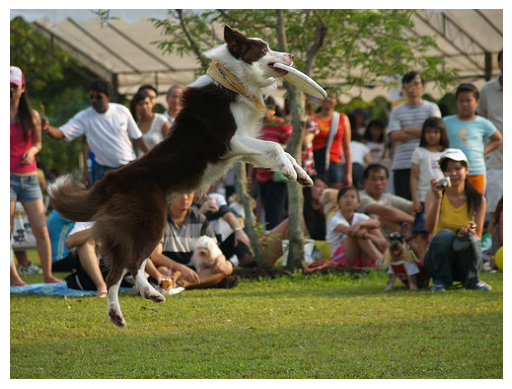

500    A black and white Border Collie catches a Fris...
501    a brown and white dog catches a Frisbee in it ...
502    A brown and white dug jumping up to catch a Fr...
503    A dog jumps to catch a Frisbee , while many pe...
504    An agile dog catches a Frisbee while a crowd o...
Name: caption, dtype: object


In [5]:
n = 100
img = Image.open(IMAGE_PATH + df['image'][5*n])
plt.imshow(img)
plt.axis('off')
plt.show()
print(df['caption'][5*n:5*n+5])

<h3>Tiền xử lí text</h3>

In [6]:
import re
def caption_preprocessing(text, remove_digits = True):
    # Loại bỏ dấu câu
    pattern = r'[^a-zA-Z0-9\s]'
    text = re.sub(pattern,'',text)
    # Tách câu thành các từ và chuyển về chữ thường
    text = text.split()
    text = [word.lower() for word in text]
    # xoá các từ có chứa số và thêm bos, eos ( begin, end of sentence)
    text = [word for word in text if word.isalpha()]
    text = ' '.join(text)
    text = 'bos ' + text + ' eos'
    return text

In [7]:
text = 'i love learning88 ?? Machine .Learning, Deep Learning .'
caption_preprocessing(text)

'bos i love machine learning deep learning eos'

In [8]:
df['caption'] = df['caption'].apply(caption_preprocessing)

In [9]:
df['caption'].iloc[0]

'bos a child in a pink dress is climbing up a set of stairs in an entry way eos'

In [10]:
captions = []
for i in range(0, int(len(df)/5) -1):
    tmp_cap = []
    for j in range(0, 5):
        tmp_cap.append(df['caption'].iloc[5*i+j])
    captions.append(tmp_cap)
captions

[['bos a child in a pink dress is climbing up a set of stairs in an entry way eos',
  'bos a girl going into a wooden building eos',
  'bos a little girl climbing into a wooden playhouse eos',
  'bos a little girl climbing the stairs to her playhouse eos',
  'bos a little girl in a pink dress going into a wooden cabin eos'],
 ['bos a black dog and a spotted dog are fighting eos',
  'bos a black dog and a tricolored dog playing with each other on the road eos',
  'bos a black dog and a white dog with brown spots are staring at each other in the street eos',
  'bos two dogs of different breeds looking at each other on the road eos',
  'bos two dogs on pavement moving toward each other eos'],
 ['bos a little girl covered in paint sits in front of a painted rainbow with her hands in a bowl eos',
  'bos a little girl is sitting in front of a large painted rainbow eos',
  'bos a small girl in the grass plays with fingerpaints in front of a white canvas with a rainbow on it eos',
  'bos there

In [11]:
from collections import Counter
word_counts = Counter() # đếm số lượng từng từ xuất hiện trong toàn bộ tập data
max_length = 0          # độ dài tối đa của 1 câu trong tập data
vocab = []
for text in df['caption']:
    words = text.split()
    if len(words) > max_length:
        max_length = len(words)
    word_counts.update(words)
# print(word_counts)
word_counts_threshold = 10   # ở đây ta chỉ lấy các từ xuất hiện từ 10 lần trở lên trong data để giảm số từ trong từ điển
for word, count in word_counts.items():
    if count >= word_counts_threshold:
        vocab.append(word)
len(vocab)

1952

In [12]:
index_to_word = {}
word_to_index = {}
index = 1
for word in vocab:      # gán mỗi từ trong từ điển với 1 số để dễ xử lý sau này
    index_to_word[index] = word      
    word_to_index[word] = index
    index += 1

In [13]:
# embedding_values = {}
# file = open('glove.6B.300d.txt', encoding='utf-8')
# for line in file:
#     values = line.split()
#     word = values[0]
#     coefs = np.asarray(values[1:], dtype = 'float32')
#     embedding_values[word] = coefs
# file.close()
# print('Found %s word vectors.' % len(embedding_values))

In [13]:
embedding_dim = 300
vocab_size = len(vocab) + 1
# embedding_matrix = np.zeros((vocab_size, embedding_dim))

In [15]:
# for word, i in word_to_index.items():
#     tmp_vector = embedding_values.get(word)
#     if tmp_vector is not None:
#         embedding_matrix[i] = tmp_vector
# print(embedding_matrix.shape)

# with open('embedding_matrix.pkl', 'wb') as file:
#     dump(embedding_matrix, file)

In [14]:
embedding_matrix = load(open('embedding_matrix.pkl', 'rb'))

In [16]:
import torchvision
from torchvision import transforms, models

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [18]:
# resnet = models.resnet50(pretrained=True)
# resnet = torch.nn.Sequential(*(list(resnet.children())[:-1]))  # Bỏ lớp phân loại cuối cùng
# resnet.eval()

# features = []
# for path in img_path:
#     image = Image.open(path).convert('RGB')
#     image = transform(image).unsqueeze(0)
#     with torch.no_grad():
#         feature = resnet(image).squeeze(0)
#     features.append(feature.cpu().numpy())

# np.save('image_features.npy', np.array(features))

C:\Users\DuyAnh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\DuyAnh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [18]:
from torch.utils.data import Dataset, DataLoader

def padding_seq(in_seq, max_length):
    return in_seq + [0] * (max_length - len(in_seq))

class CustomDataSet(Dataset):
    def __init__(self, img_features_file, captions, w2i, transform=None):
        self.img_features = np.load(img_features_file)
        self.captions = captions
        self.w2i = w2i
        self.transform = transform

    def __len__(self):
        return len(self.captions)
    
    def __getitem__(self, idx):
        img_feature = self.img_features[idx]
        
        X_seq, y_seq = [], []
        for cap in self.captions[idx]:
            seq = [self.w2i[word] for word in cap.split(' ') if word in self.w2i]
            for i in range(1, len(seq)):
                in_seq = padding_seq(seq[:i], max_length=max_length)
                out_seq = [0] * vocab_size
                out_seq[seq[i]] = 1
                X_seq.append(torch.tensor(in_seq, dtype = torch.long))
                y_seq.append(torch.tensor(out_seq, dtype = torch.float))
                # print(len(X_seq))
        
        return image, torch.stack(X_seq), torch.stack(y_seq)

In [19]:
class ImageCaptioningModel(nn.Module):
    def __init__(self):
        super(ImageCaptioningModel, self).__init__()

        self.image_fc = nn.Linear(2048, 256)
        # Tầng embedding
        self.embedding = nn.Embedding(vocab_size, 300)
        self.embedding.weight = nn.Parameter(torch.tensor(embedding_matrix, dtype = torch.float))
        self.embedding.weight.requires_grad = False
        
        self.dropout = nn.Dropout(0.5)
        self.lstm = nn.LSTM(300, 256)

        # Sinh caption
        self.fc = nn.Linear(256, vocab_size)

    def forward(self, image_features, in_seq):
        image_features = image_features.squeeze()
        image_features = image_features.clone().detach().requires_grad_(True)
        image_features = self.image_fc(image_features)
        embeddings = self.embedding(in_seq)
        embeddings = self.dropout(embeddings)
        lstm_out, (hn, cn) = self.lstm(embeddings)
        # print(hn, hn.shape)
        last_hidden_state = hn[:,-1,:]
        # print(last_hidden_state.shape)
        combined = image_features + last_hidden_state
        outputs = self.fc(combined)
        # print(outputs)
        return outputs

In [20]:
model = ImageCaptioningModel()

In [26]:
dataset = CustomDataSet(img_path=img_path, captions=captions, w2i=word_to_index, transform=transform)
data_loader = DataLoader(dataset=dataset, batch_size=1, shuffle=True)

In [27]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params = model.parameters(), lr = 0.001)

In [28]:
resnet = torchvision.models.resnet50(pretrained = True)
resnet = nn.Sequential(*list(resnet.children())[:-1])

C:\Users\DuyAnh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\DuyAnh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [33]:
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for images, in_seqs, out_seqs in tqdm(data_loader):
        with torch.no_grad():
            image_features = resnet(images)
        image_features = image_features.squeeze(dim=-1).squeeze(dim=-1)
        for i in range(in_seqs.size(1)):
            input_seq = in_seqs[:, i, :]
            output_seq =out_seqs[:, i, :]
            predict = model(image_features, input_seq)
            loss = loss_fn(predict, output_seq)
            optimizer.zero_grad()
            loss.backward()
            total_loss += loss.item()
        
        optimizer.step()

    avg_loss = total_loss / len(data_loader)
    print(f'loss: {avg_loss:.4f}')

  0%|          | 0/8091 [00:00<?, ?it/s]

  0%|          | 28/8091 [00:14<1:09:15,  1.94it/s]


KeyboardInterrupt: 